In [15]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from textblob import TextBlob
import subprocess



# Set paths
ROOT = os.getcwd()
DATA_DIR = os.path.join(ROOT, "data")
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
MERGED_DIR = os.path.join(DATA_DIR, "merged")
ENRICHED_DIR  = os.path.join(DATA_DIR, "enriched")

for folder in [DATA_DIR, RAW_DIR, PROCESSED_DIR, MERGED_DIR, ENRICHED_DIR]:
    os.makedirs(folder, exist_ok=True)

# Commodity tickers, price columns
tickers = {
    "Gold": "GC=F",
    "WTI": "CL=F",
    "Wheat": "ZW=F",
    "NaturalGas":"UNG",
    "Copper": "HG=F",
    "Lithium": "LIT"
}
price_cols = {
    "Gold": "Close_GC=F",
    "WTI": "Close_CL=F",
    "Wheat": "Close_ZW=F",
    "NaturalGas":"Close_UNG",
    "Copper": "Close_HG=F",
    "Lithium": "Close_LIT"
}
START = "2000-01-01"
END = None

In [16]:
def download_kaggle(dataset, to_folder):
    os.makedirs(to_folder, exist_ok=True)
    subprocess.run([
        "kaggle", "datasets", "download", "-d", dataset, "-p", to_folder, "--unzip"
    ], check=True)
    print(f"Kaggle dataset {dataset} downloaded.")

download_kaggle("therohk/million-headlines", RAW_DIR)



Kaggle dataset therohk/million-headlines downloaded.


In [17]:
# Utility: Flatten columns (for yfinance MultiIndex)
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(filter(None, map(str, col))).strip() for col in df.columns.values]
    return df

# Download and process commodity prices
def download_commodity(ticker, name):
    df = yf.download(ticker, start=START, end=END, auto_adjust=True)
    if df.empty:
        print(f"Warning: Empty data for {name}")
        return pd.DataFrame()
    df = flatten_columns(df)
    df.reset_index(inplace=True)
    df.to_csv(os.path.join(RAW_DIR, f"{name.lower()}_raw.csv"), index=False)
    return df

def feature_engineer(df, price_col):
    df = df.copy()
    df = df.sort_values("Date").drop_duplicates("Date")
    df["Return"] = df[price_col].pct_change()
    df["MA_5"]   = df[price_col].rolling(5).mean()
    df["Vol_5"]  = df["Return"].rolling(5).std()
    df["Return_lag1"] = df["Return"].shift(1)
    df["Return_lag10"] = df["Return"].shift(10)
    df = df.dropna(subset=[price_col, "Return", "MA_5", "Vol_5", "Return_lag1", 'Return_lag10']).reset_index(drop=True)
    return df

# Load GPR
def load_gpr():
    gpr_path = os.path.join(RAW_DIR, "All_Historical_Data_Separately", "Geopolitical Risk Index Daily.csv")
    gpr = pd.read_csv(gpr_path)
    gpr['DATE'] = pd.to_datetime(gpr['DATE'], errors='coerce')
    gpr = gpr.dropna(subset=['DATE'])
    gpr = gpr.drop_duplicates(subset=['DATE']).sort_values('DATE').reset_index(drop=True)
    gpr_daily = gpr.set_index('DATE').resample('D').ffill().reset_index()
    return gpr_daily

In [18]:
# Load the news CSV
# news_df = pd.read_csv(os.path.join(RAW_DIR, "data.csv"))
# # Convert 'published_at' to datetime
# news_df['published_at'] = pd.to_datetime(news_df['published_at'], errors='coerce')
#
# # Create a 'date' column (just the date part, not time)
# news_df['date'] = news_df['published_at'].dt.date
# print(news_df[['published_at', 'date']].head())


news_df = pd.read_csv(os.path.join(RAW_DIR, "abcnews-date-text.csv"))
# Add a datetime 'date' column from yyyymmdd string
news_df['date'] = pd.to_datetime(news_df['publish_date'].astype(str), format='%Y%m%d', errors='coerce')


# Now you can use 'date' for grouping, merging, and feature engineering
# news_features = extract_news_features(news_df, geo_keywords)


# Code for the abc news datasets

In [19]:
# Use a robust, expanded geopolitical keywords list
geo_keywords = [
    'war', 'wars', 'sanctions', 'sanction', 'conflict', 'conflicts', 'geopolitical', 'tension', 'tensions',
'embargo', 'embargoes', 'crisis', 'crises', 'invasion', 'invasions', 'terrorism', 'opec', 'blockade',
'blockades', 'dispute', 'disputes', 'escalation', 'escalations', 'hostility', 'hostilities', 'unrest',
'strike', 'strikes', 'alliance', 'alliances', 'treaty', 'treaties', 'summit', 'summits', 'diplomacy',
'iran', 'syria', 'syrian', 'libya', 'lybian', 'iraq', 'north korea', 'ukraine', 'russia', 'china', 'trade war', 'trade wars',
'missile', 'missiles', 'military', 'nuclear', 'sanctioned', 'ceasefire', 'ceasefires', 'negotiation',
'negotiations', 'occupation', 'occupations', 'regime', 'regimes', 'rebel', 'rebels', 'protest', 'protests',
'cyberattack', 'cyberattacks', 'espionage', 'border', 'borders', 'refugee', 'refugees', 'intervention',
'interventions', 'pipeline', 'pipelines', 'tariff', 'tariffs', 'boycott', 'boycotts', 'expulsion',
'expulsions', 'diplomat', 'diplomats', 'embassy', 'embassies', 'coalition', 'coalitions', 'genocide',
'genocides', 'hostage', 'hostages', 'radical', 'radicals', 'siege', 'sieges', 'nato', 'chechen', 'lebanon', 'yemen', 'taliban', 'islamist', 'afghanistan', 'kabul', 'saddam hussein', 'global financial crisis', 'economic recession', 'economic recessions', 'chaos', 'unemployment', 'instability','insolvency', 'credit crunch', 'unpayable debts', 'abkhazia', 'ossetia', 'separatists', 'donetsk', 'luhansk', 'south sudan', 'jihadism', 'palestine', 'palestinian', 'isis', 'crimea', 'annexation', 'houthi', 'migration crises', 'donbas', 'arab spring', 'kosovo', 'ukraine war', 'ukraine conflict', 'AFU'
]

def extract_news_features_abc(news_df, keywords):
    news_df = news_df.copy()
    news_df['geo_keyword_hits'] = news_df['headline_text'].apply(
        lambda text: sum(kw in text for kw in keywords if isinstance(text, str))
    )
    # Sentiment works on string input
    news_df['sentiment'] = news_df['headline_text'].apply(
        lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0
    )
    news_daily = news_df.groupby('date').agg({
        'geo_keyword_hits': 'sum',
        'sentiment': 'mean'
    }).reset_index().dropna(subset=['date']).sort_values('date')
    return news_daily

news_features = extract_news_features_abc(news_df, geo_keywords)
print(news_features.head())

        date  geo_keyword_hits  sentiment
0 2003-02-19                36   0.005259
1 2003-02-20                45   0.016552
2 2003-02-21                38   0.004962
3 2003-02-22                29   0.030703
4 2003-02-23                30   0.001185


In [22]:
# Main ETL and merge
gpr_daily = load_gpr()
merged_data = {}
# Standardize column names and types
# df_feat['Date'] = pd.to_datetime(df_feat['Date'])
gpr_daily = gpr_daily.rename(columns={'DATE': 'Date'})
gpr_daily['Date'] = pd.to_datetime(gpr_daily['Date'])
gpr_daily = gpr_daily.sort_values('Date')


news_features = news_features.rename(columns={'date': 'Date'})
news_features['Date'] = pd.to_datetime(news_features['Date'])
news_features = news_features.sort_values('Date')


# Sort all DataFrames by 'Date'
df_feat = df_feat.sort_values('Date')

#.sort_values('DATE').rename(columns={'DATE':'Date'})
for name, ticker in tickers.items():
    price_col = price_cols[name]
    df_price = download_commodity(ticker, name)
    if df_price.empty:
        continue
    df_feat = feature_engineer(df_price, price_col)
    df_merge = pd.merge_asof(df_feat.sort_values('Date'),
                             gpr_daily,
                             on='Date', direction='backward')
    df_merge = pd.merge_asof(df_merge.sort_values('Date'),
                             news_features.sort_values('Date'),
                             on='Date', direction='backward')
    # Event dummy
    if 'EVENT' in df_merge.columns:
        df_merge['event_dummy'] = df_merge['EVENT'].notna().astype(int)
    else:
        df_merge['event_dummy'] = 0
    # Save output
    fname = f"{name.lower()}_enriched.csv"
    df_merge.to_csv(os.path.join(MERGED_DIR, fname), index=False)
    merged_data[name] = df_merge

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# clean version below

In [23]:
# Standardize GPR and News Features BEFORE LOOP (do this ONCE)
gpr_daily = load_gpr()
gpr_daily = gpr_daily.rename(columns={'DATE': 'Date'})  # Rename ONLY IF NEEDED
gpr_daily['Date'] = pd.to_datetime(gpr_daily['Date'])
gpr_daily = gpr_daily.sort_values('Date').reset_index(drop=True)

news_features = news_features.rename(columns={'date': 'Date'})  # Rename ONLY IF NEEDED
news_features['Date'] = pd.to_datetime(news_features['Date'])
news_features = news_features.sort_values('Date').reset_index(drop=True)

merged_data = {}

for name, ticker in tickers.items():
    price_col = price_cols[name]
    df_price = download_commodity(ticker, name)
    if df_price.empty:
        continue
    df_feat = feature_engineer(df_price, price_col)

    # Standardize df_feat 'Date' column
    df_feat['Date'] = pd.to_datetime(df_feat['Date'])
    df_feat = df_feat.sort_values('Date').reset_index(drop=True)

    # ETL merge part: merge_asof expects sorted 'Date' columns in each DataFrame
    df_merge = pd.merge_asof(df_feat,
                             gpr_daily,
                             on='Date', direction='backward')
    df_merge = pd.merge_asof(df_merge,
                             news_features,
                             on='Date', direction='backward')

    # Event dummy: create if missing
    if 'EVENT' in df_merge.columns:
        df_merge['event_dummy'] = df_merge['EVENT'].notna().astype(int)
    else:
        df_merge['event_dummy'] = 0

    # Save output
    fname = f"{name.lower()}_enriched.csv"
    df_merge.to_csv(os.path.join(MERGED_DIR, fname), index=False)
    merged_data[name] = df_merge


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# code below possibly useless

In [24]:
# Standardize and sort gpr_daily and news_features once
gpr_daily = load_gpr()
gpr_daily = gpr_daily.rename(columns={'DATE': 'Date'})
gpr_daily['Date'] = pd.to_datetime(gpr_daily['Date'])
gpr_daily = gpr_daily.sort_values('Date')

news_features = news_features.rename(columns={'date': 'Date'})
news_features['Date'] = pd.to_datetime(news_features['Date'])
news_features = news_features.sort_values('Date')

merged_data = {}

for name, ticker in tickers.items():
    price_col = price_cols[name]
    df_price = download_commodity(ticker, name)
    if df_price.empty:
        continue
    df_feat = feature_engineer(df_price, price_col)
    # Standardize and sort df_feat
    df_feat['Date'] = pd.to_datetime(df_feat['Date'])
    df_feat = df_feat.sort_values('Date')
    # Merge
    df_merge = pd.merge_asof(df_feat, gpr_daily, on='Date', direction='backward')
    df_merge = pd.merge_asof(df_merge, news_features, on='Date', direction='backward')
    # Event dummy
    if 'EVENT' in df_merge.columns:
        df_merge['event_dummy'] = df_merge['EVENT'].notna().astype(int)
    else:
        df_merge['event_dummy'] = 0
    # Save output
    fname = f"{name.lower()}_enriched.csv"
    df_merge.to_csv(os.path.join(ENRICHED_DIR, fname), index=False)
    merged_data[name] = df_merge


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [25]:
for name, df in merged_data.items():
    print(f"\n{name} Correlation Matrix:")
    print(df[['Return', 'MA_5', 'Vol_5', 'GPRD', 'geo_keyword_hits', 'sentiment', "Return_lag10"]].corr())

end_date = pd.to_datetime("2021-12-31")

for name, df in merged_data.items():
    # Trim dataframes to geo news coverage period
    merged_data[name] = df[df['Date'] <= end_date].reset_index(drop=True)




Gold Correlation Matrix:
                    Return      MA_5     Vol_5      GPRD  geo_keyword_hits  \
Return            1.000000  0.002984 -0.028218  0.002311         -0.013067   
MA_5              0.002984  1.000000  0.017293 -0.070822         -0.646558   
Vol_5            -0.028218  0.017293  1.000000 -0.033182          0.099344   
GPRD              0.002311 -0.070822 -0.033182  1.000000         -0.145278   
geo_keyword_hits -0.013067 -0.646558  0.099344 -0.145278          1.000000   
sentiment         0.000314  0.257640 -0.026756  0.154068         -0.239586   
Return_lag10     -0.000397  0.019164  0.006824  0.006588         -0.018011   

                  sentiment  Return_lag10  
Return             0.000314     -0.000397  
MA_5               0.257640      0.019164  
Vol_5             -0.026756      0.006824  
GPRD               0.154068      0.006588  
geo_keyword_hits  -0.239586     -0.018011  
sentiment          1.000000     -0.004983  
Return_lag10      -0.004983      1.000000


--- EDA for Gold ---
            Return         MA_5        Vol_5  Return_lag1  geo_keyword_hits  \
count  5342.000000  5342.000000  5342.000000  5342.000000       4740.000000   
mean      0.000418  1037.691516     0.009638     0.000416         24.276793   
std       0.011086   496.430245     0.005526     0.011086         10.433289   
min      -0.093538   257.220007     0.000449    -0.093538          0.000000   
25%      -0.004820   549.474988     0.005942    -0.004820         17.000000   
50%       0.000464  1189.979993     0.008465     0.000463         24.000000   
75%       0.006200  1347.560004     0.011776     0.006191         31.000000   
max       0.090277  2023.659985     0.053630     0.090277         94.000000   

         sentiment  Return_lag10  
count  4740.000000   5342.000000  
mean      0.016337      0.000414  
std       0.016647      0.011087  
min      -0.090000     -0.093538  
25%       0.006244     -0.004820  
50%       0.016031      0.000451  
75%       0.025661   

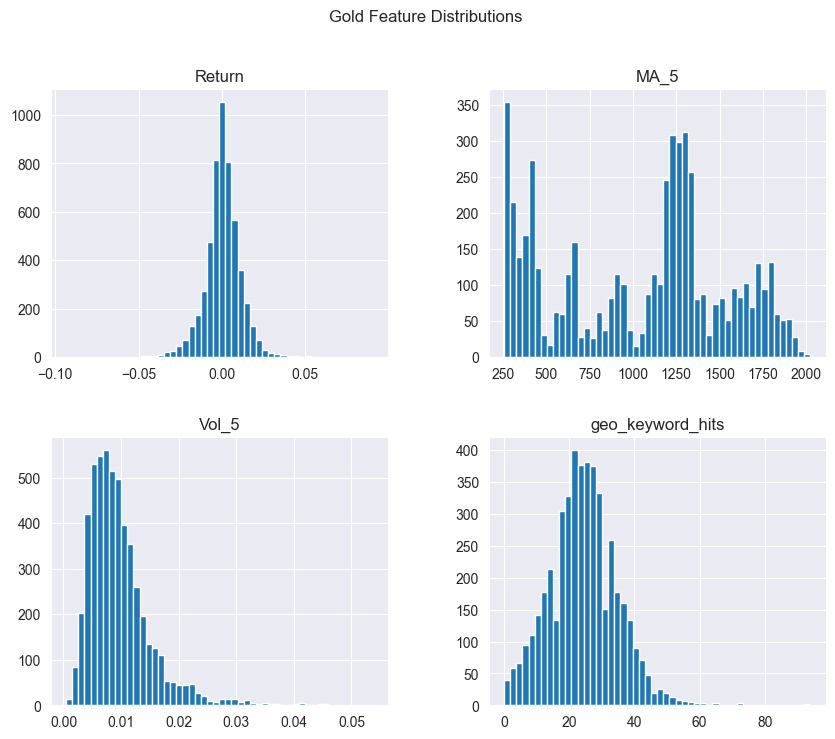

ADF Test for Price:
ADF Statistic: -0.817, p-value: 8.141e-01
ADF Test for Return:
ADF Statistic: -23.431, p-value: 0.000e+00


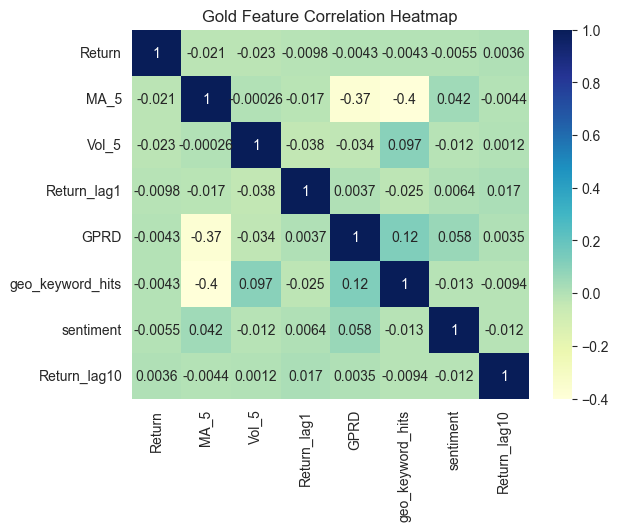

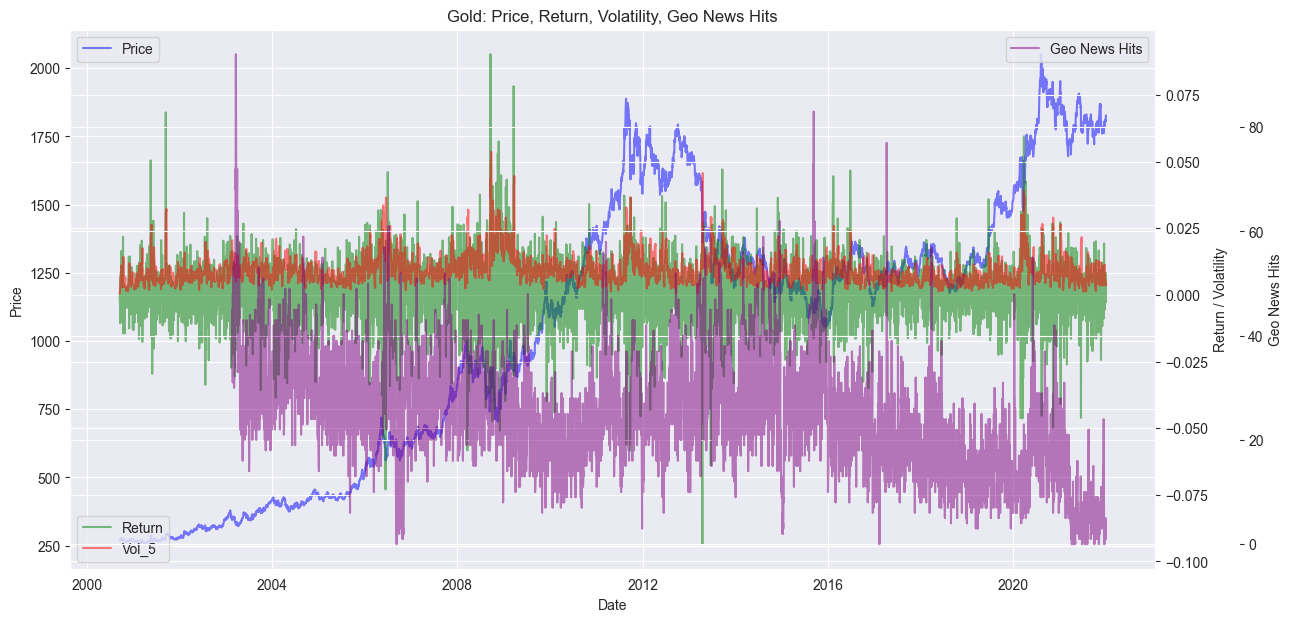


--- EDA for WTI ---
            Return         MA_5        Vol_5  Return_lag1  geo_keyword_hits  \
count  5351.000000  5351.000000  5351.000000  5351.000000       4744.000000   
mean     -0.000208    62.191138     0.022519    -0.000202         24.276981   
std       0.052425    25.358765     0.045422     0.052424         10.431044   
min      -3.059661     3.920000     0.001544    -3.059661          0.000000   
25%      -0.012453    43.000000     0.012351    -0.012450         17.000000   
50%       0.001009    59.395999     0.017944     0.001020         24.000000   
75%       0.013243    81.218999     0.025210     0.013243         31.000000   
max       0.376623   142.239999     1.446609     0.376623         94.000000   

         sentiment  Return_lag10  
count  4744.000000   5351.000000  
mean      0.016353     -0.000197  
std       0.016649      0.052420  
min      -0.090000     -3.059661  
25%       0.006264     -0.012444  
50%       0.016040      0.001009  
75%       0.025681    

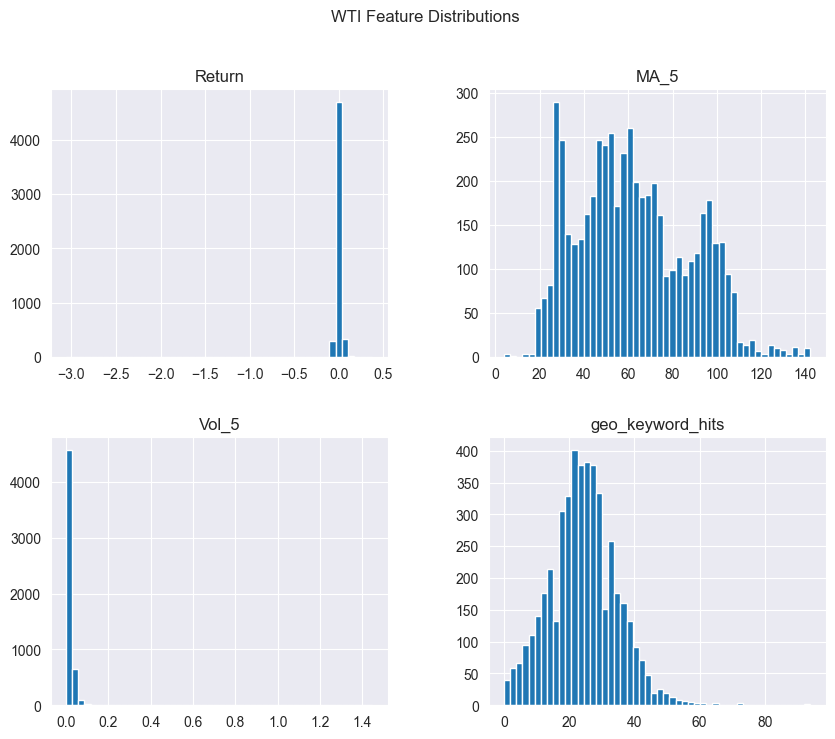

ADF Test for Price:
ADF Statistic: -2.585, p-value: 9.620e-02
ADF Test for Return:
ADF Statistic: -13.567, p-value: 2.255e-25


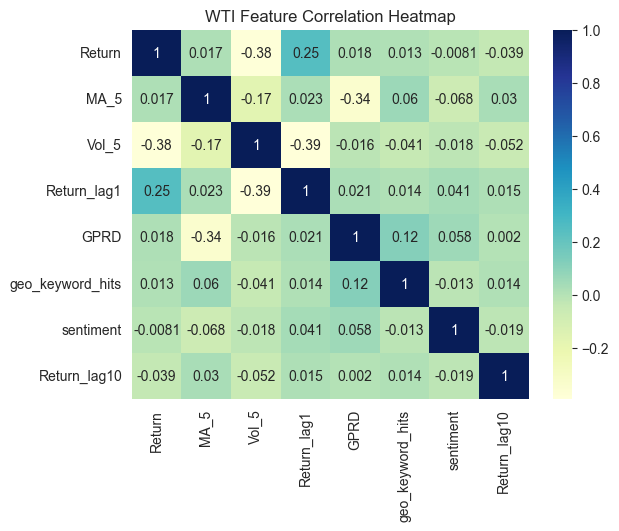

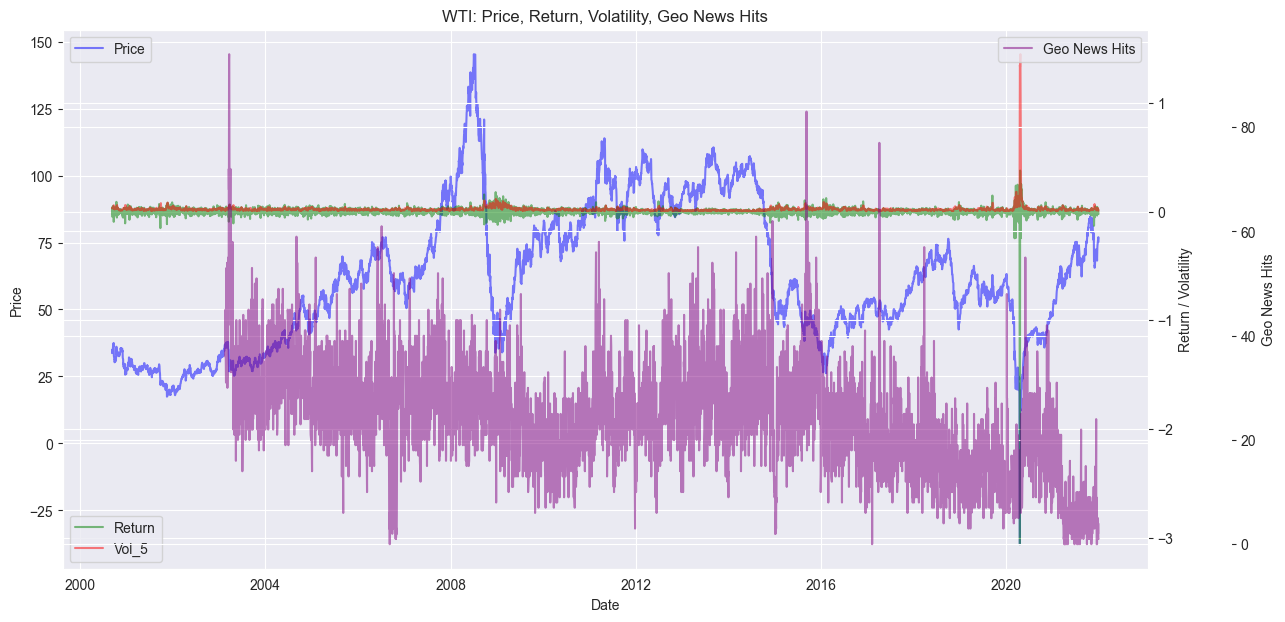


--- EDA for Wheat ---
            Return         MA_5        Vol_5  Return_lag1  geo_keyword_hits  \
count  5367.000000  5367.000000  5367.000000  5367.000000       4751.000000   
mean      0.000410   514.694019     0.017919     0.000410         24.278047   
std       0.019876   170.923728     0.008797     0.019875         10.416239   
min      -0.094917   235.550000     0.001420    -0.094917          0.000000   
25%      -0.011935   381.875000     0.011780    -0.011935         18.000000   
50%      -0.000428   497.900000     0.016376    -0.000428         24.000000   
75%       0.011763   632.825000     0.021964     0.011763         31.000000   
max       0.091926  1208.800000     0.084186     0.091926         94.000000   

         sentiment  Return_lag10  
count  4751.000000   5367.000000  
mean      0.016354      0.000411  
std       0.016635      0.019869  
min      -0.090000     -0.094917  
25%       0.006255     -0.011905  
50%       0.016043     -0.000428  
75%       0.025668  

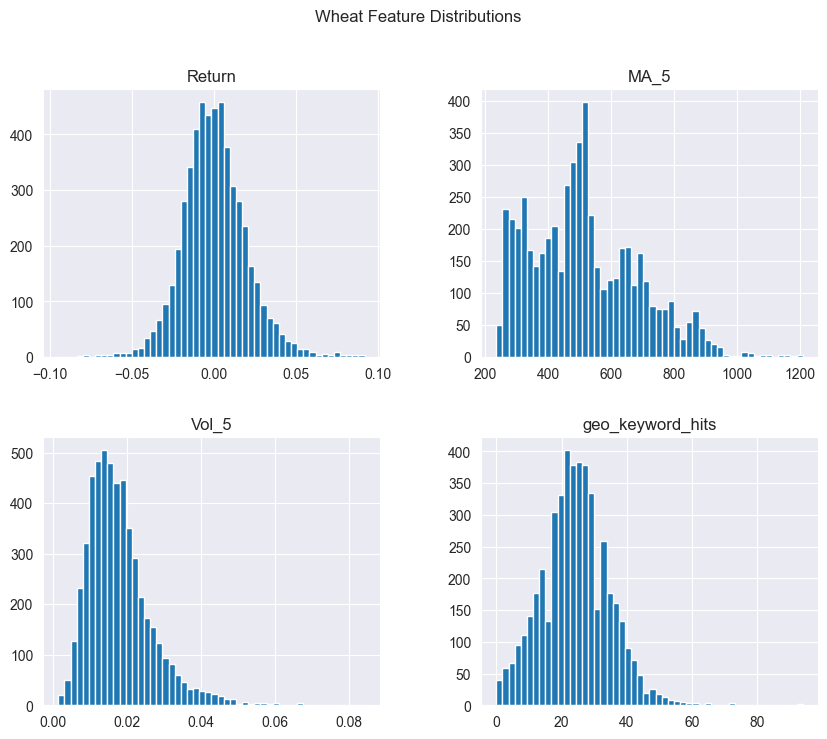

ADF Test for Price:
ADF Statistic: -2.306, p-value: 1.701e-01
ADF Test for Return:
ADF Statistic: -14.474, p-value: 6.543e-27


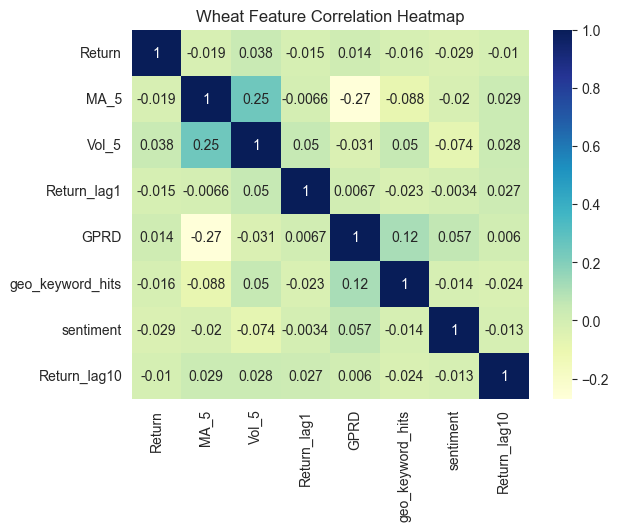

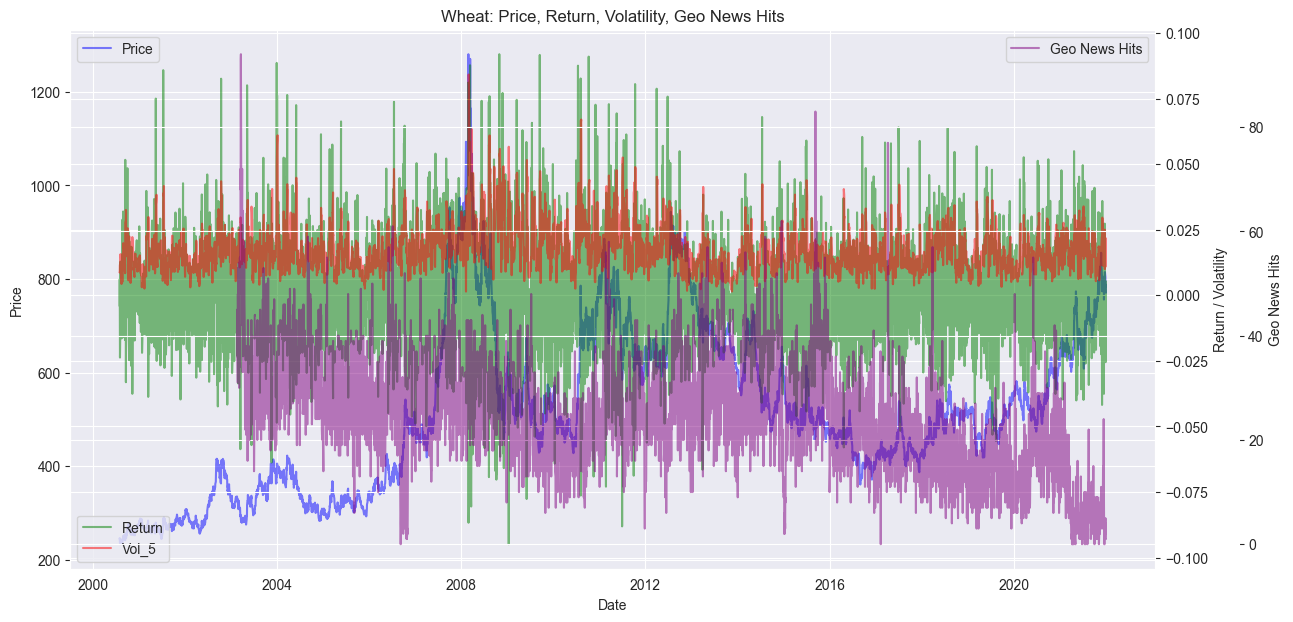


--- EDA for NaturalGas ---
            Return         MA_5        Vol_5  Return_lag1  geo_keyword_hits  \
count  3694.000000  3694.000000  3694.000000  3694.000000       3694.000000   
mean     -0.000941   958.098556     0.024521    -0.000954         22.538441   
std       0.027550  1692.185825     0.012951     0.027538          9.934555   
min      -0.191251    35.632000     0.003104    -0.191251          0.000000   
25%      -0.017238    98.428000     0.015883    -0.017238         16.000000   
50%      -0.001403   287.087997     0.021714    -0.001403         22.000000   
75%       0.014760   748.095999     0.029932     0.014742         29.000000   
max       0.188993  8069.376074     0.144606     0.188993         83.000000   

         sentiment  Return_lag10  
count  3694.000000   3694.000000  
mean      0.016110     -0.000944  
std       0.017167      0.027479  
min      -0.070115     -0.191251  
25%       0.005542     -0.017227  
50%       0.015740     -0.001392  
75%       0.025

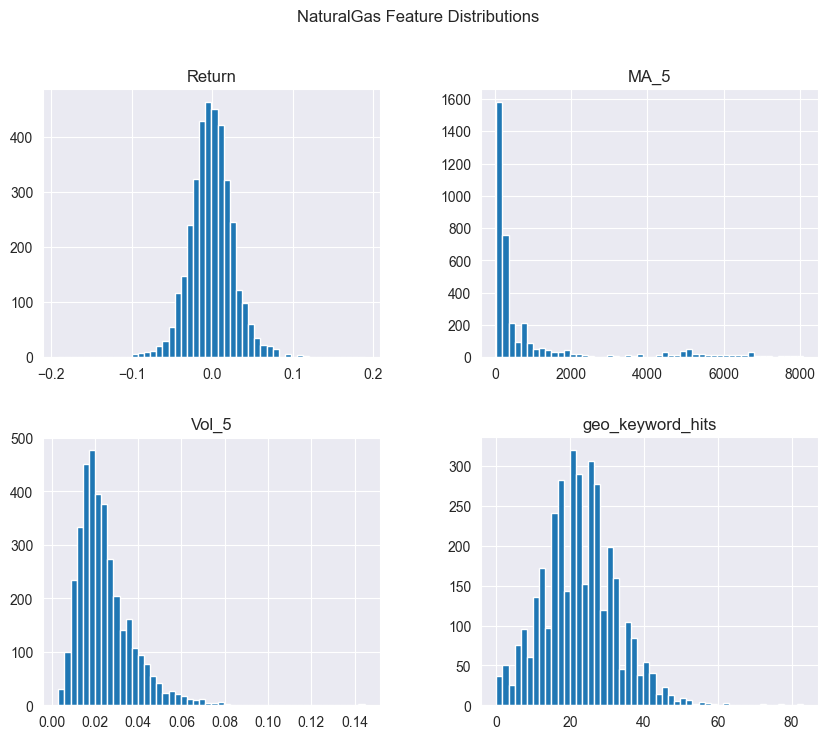

ADF Test for Price:
ADF Statistic: -3.412, p-value: 1.056e-02
ADF Test for Return:
ADF Statistic: -28.879, p-value: 0.000e+00


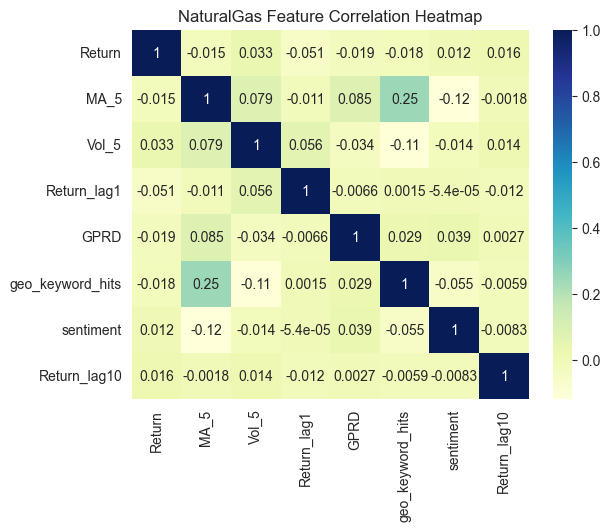

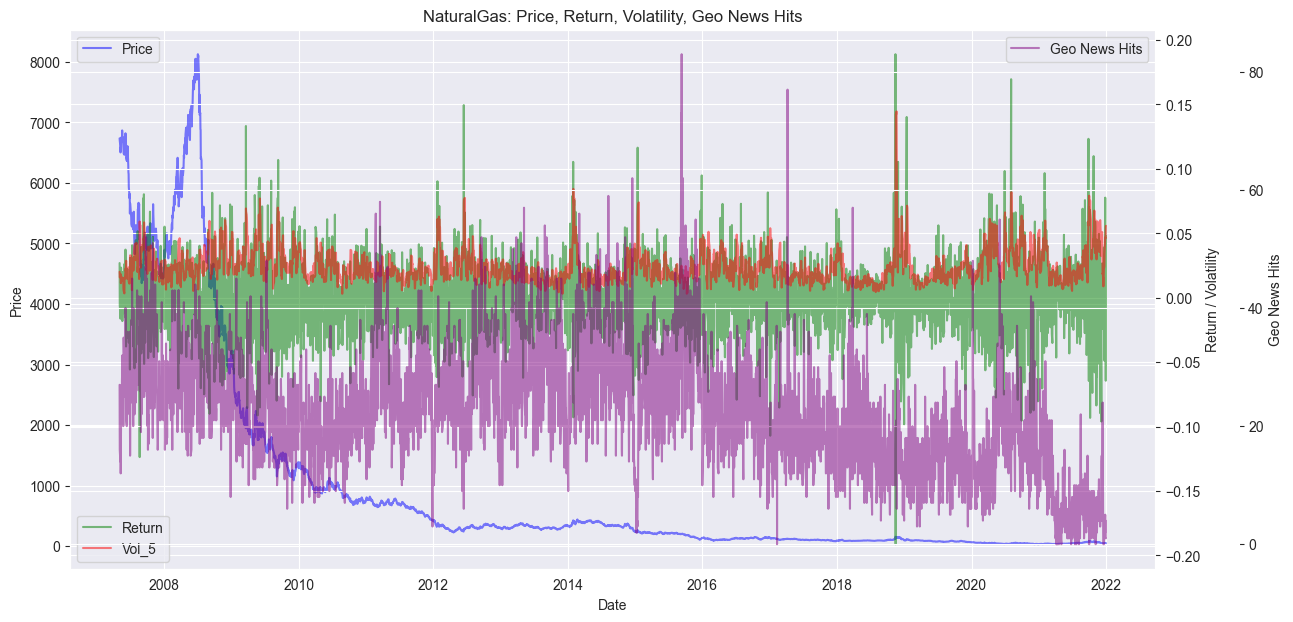


--- EDA for Copper ---
            Return         MA_5        Vol_5  Return_lag1  geo_keyword_hits  \
count  5346.000000  5346.000000  5346.000000  5346.000000       4743.000000   
mean      0.000439     2.586139     0.014780     0.000436         24.268396   
std       0.017050     1.073002     0.008959     0.017048         10.434683   
min      -0.110355     0.611100     0.000770    -0.110355          0.000000   
25%      -0.008279     1.743775     0.008916    -0.008279         17.000000   
50%       0.000182     2.786900     0.012681     0.000175         24.000000   
75%       0.009174     3.357500     0.017932     0.009160         31.000000   
max       0.124898     4.747200     0.089962     0.124898         94.000000   

         sentiment  Return_lag10  
count  4743.000000   5346.000000  
mean      0.016351      0.000441  
std       0.016646      0.017048  
min      -0.090000     -0.110355  
25%       0.006264     -0.008272  
50%       0.016038      0.000190  
75%       0.025688 

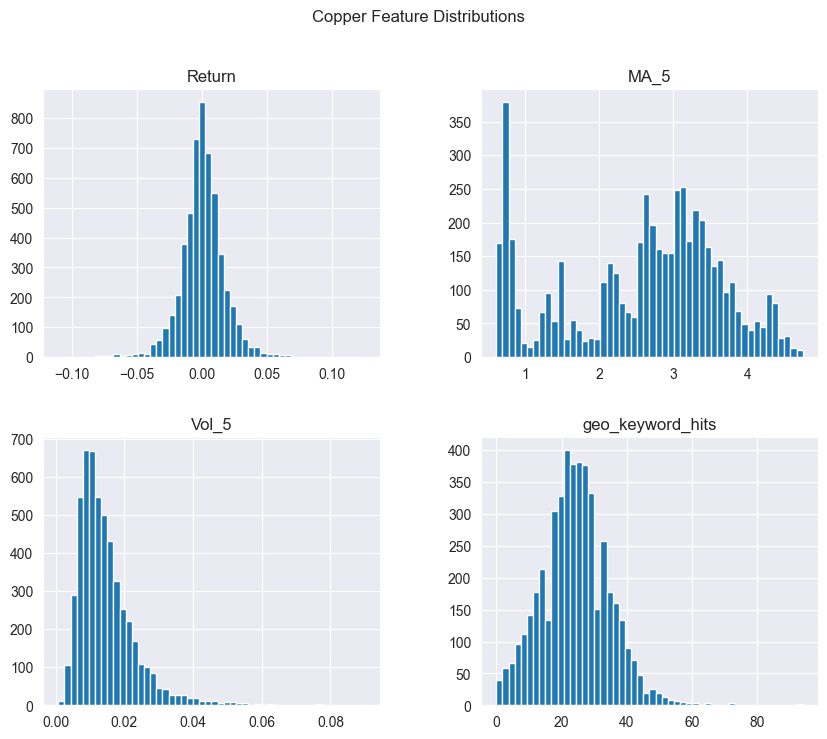

ADF Test for Price:
ADF Statistic: -1.600, p-value: 4.835e-01
ADF Test for Return:
ADF Statistic: -19.566, p-value: 0.000e+00


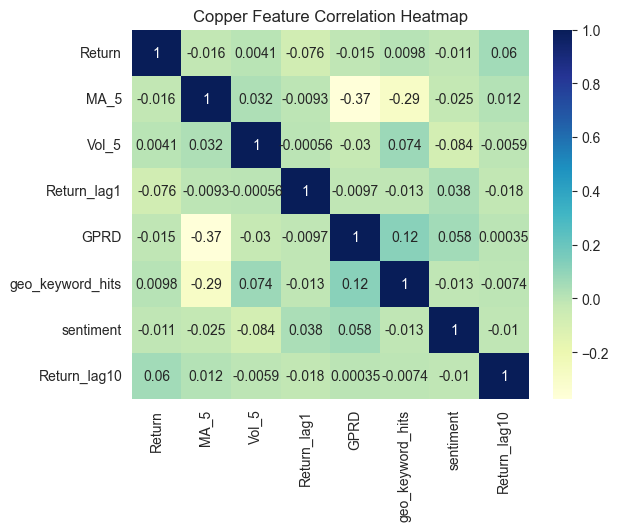

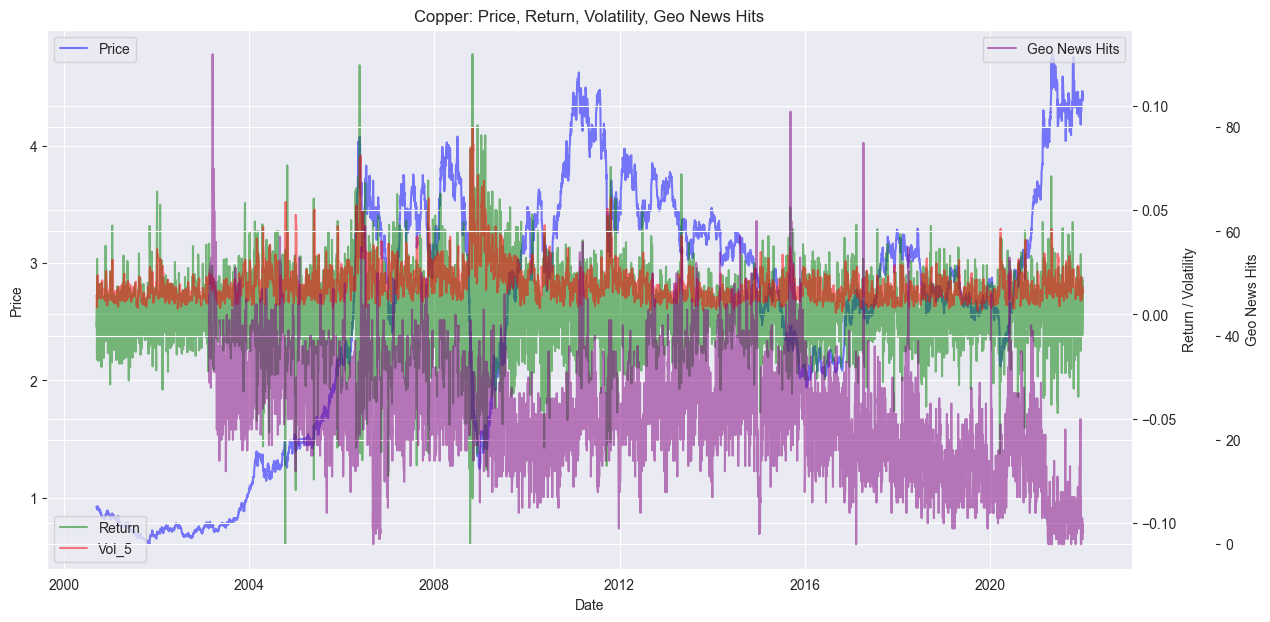


--- EDA for Lithium ---
            Return         MA_5        Vol_5  Return_lag1  geo_keyword_hits  \
count  2871.000000  2871.000000  2871.000000  2871.000000       2871.000000   
mean      0.000513    30.099519     0.014051     0.000512         21.845698   
std       0.017040    14.824321     0.009310     0.017041         10.391846   
min      -0.135835    15.143249     0.001797    -0.135835          0.000000   
25%      -0.007488    21.980808     0.008182    -0.007542         15.000000   
50%       0.000784    25.217941     0.011910     0.000784         21.000000   
75%       0.009075    31.427055     0.017304     0.009075         28.000000   
max       0.148924    91.842497     0.086967     0.148924         83.000000   

         sentiment  Return_lag10  
count  2871.000000   2871.000000  
mean      0.017488      0.000544  
std       0.017921      0.017026  
min      -0.070115     -0.135835  
25%       0.006695     -0.007488  
50%       0.017307      0.000784  
75%       0.027249

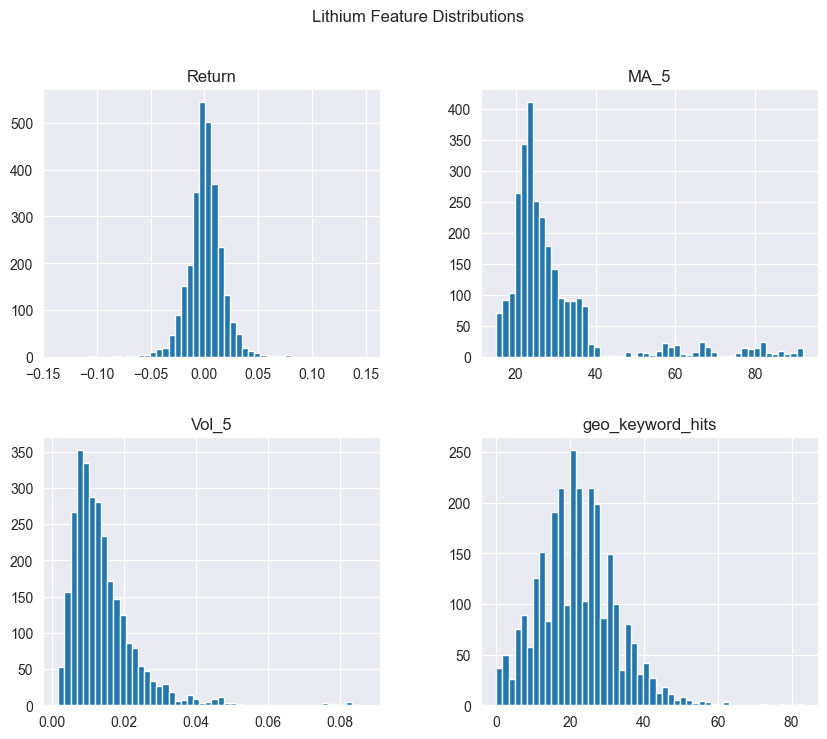

ADF Test for Price:
ADF Statistic: 0.536, p-value: 9.859e-01
ADF Test for Return:
ADF Statistic: -16.119, p-value: 4.923e-29


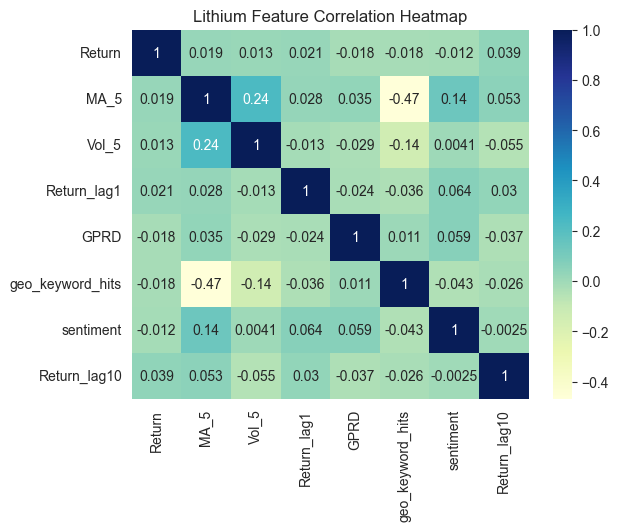

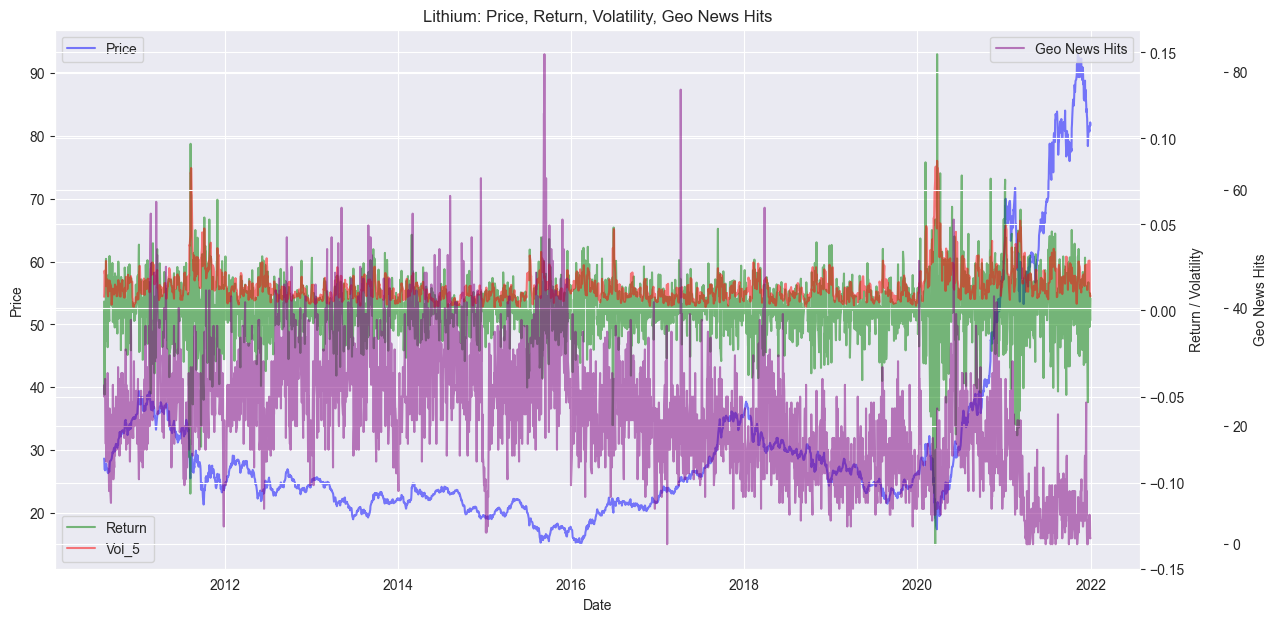

In [26]:
# --- EDA: Correlations, Stationarity, Distributions ---
# add return lag10,
for name, df in merged_data.items():
    print(f"\n--- EDA for {name} ---")
    print(df[['Return','MA_5','Vol_5','Return_lag1','GPRD','geo_keyword_hits','sentiment', "Return_lag10"]].describe())
    # Correlations
    print("Correlation matrix:\n", df[['Return','MA_5','Vol_5','Return_lag1','GPRD','geo_keyword_hits','sentiment', "Return_lag10"]].corr())
    # Distribution plots
    df[['Return','MA_5','Vol_5','GPRD','geo_keyword_hits']].hist(figsize=(10,8), bins=50)
    plt.suptitle(f'{name} Feature Distributions')
    plt.show()
    # Stationarity test
    print("ADF Test for Price:")
    adf_result = adfuller(df[price_cols[name]])
    print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3e}")
    print("ADF Test for Return:")
    adf_result = adfuller(df['Return'])
    print(f"ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3e}")
    # Correlation heatmap
    corr = df[['Return','MA_5','Vol_5','Return_lag1','GPRD','geo_keyword_hits','sentiment', "Return_lag10"]].corr()
    sns.heatmap(corr, annot=True, cmap='YlGnBu')
    plt.title(f'{name} Feature Correlation Heatmap')
    plt.show()
    # Time series multi-axis plot for enriched features (example)
    fig, ax1 = plt.subplots(figsize=(14,7))
    ax1.plot(df['Date'], df[price_cols[name]], label='Price', color='blue', alpha=0.5)
    ax2 = ax1.twinx()
    ax2.plot(df['Date'], df['Return'], label='Return', color='green', alpha=0.5)
    ax2.plot(df['Date'], df['Vol_5'], label='Vol_5', color='red', alpha=0.5)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(df['Date'], df['geo_keyword_hits'], label='Geo News Hits', color='purple', alpha=0.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax2.set_ylabel('Return / Volatility')
    ax3.set_ylabel('Geo News Hits')
    ax1.legend(loc='upper left')
    ax2.legend(loc='lower left')
    ax3.legend(loc='upper right')
    plt.title(f'{name}: Price, Return, Volatility, Geo News Hits')
    plt.show()

# Stationarity Tests with Augmented Dickey-Fuller (ADF)

In [27]:
from statsmodels.tsa.stattools import adfuller

for name, df in merged_data.items():
    print(f"\n--- ADF Stationarity Tests for {name} ---")
    # Test price series
    adf_price = adfuller(df[price_cols[name]].dropna())
    print(f"Price: ADF Statistic={adf_price[0]:.3f}, p-value={adf_price[1]:.3g}")
    # Test returns series
    adf_return = adfuller(df['Return'].dropna())
    print(f"Return: ADF Statistic={adf_return[0]:.3f}, p-value={adf_return[1]:.3g}")

    # INTERPRET
    if adf_price[1]<0.05:
        print("Price: Stationary (reject H0)")
    else:
        print("Price: Not stationary (fail to reject H0)")
    if adf_return[1]<0.05:
        print("Return: Stationary (reject H0)")
    else:
        print("Return: Not stationary (fail to reject H0)")



--- ADF Stationarity Tests for Gold ---
Price: ADF Statistic=-0.817, p-value=0.814
Return: ADF Statistic=-23.431, p-value=0
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for WTI ---
Price: ADF Statistic=-2.585, p-value=0.0962
Return: ADF Statistic=-13.567, p-value=2.26e-25
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for Wheat ---
Price: ADF Statistic=-2.306, p-value=0.17
Return: ADF Statistic=-14.474, p-value=6.54e-27
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for NaturalGas ---
Price: ADF Statistic=-3.412, p-value=0.0106
Return: ADF Statistic=-28.879, p-value=0
Price: Stationary (reject H0)
Return: Stationary (reject H0)

--- ADF Stationarity Tests for Copper ---
Price: ADF Statistic=-1.600, p-value=0.483
Return: ADF Statistic=-19.566, p-value=0
Price: Not stationary (fail to reject H0)
Return: Stationary (reject H0)

In [28]:
from statsmodels.tsa.stattools import adfuller

for name, df in merged_data.items():
    print(f"\n--- Stationarity (ADF) for {name} ---")
    # MA5 stationarity (strong correlation with geo_keywords)
    if 'MA_5' in df.columns:
        adf_ma5 = adfuller(df['MA_5'].dropna())
        print(f"MA5:  ADF Statistic={adf_ma5[0]:.3f}, p-value={adf_ma5[1]:.3g} -- ", end="")
        print("Stationary" if adf_ma5[1]<0.05 else "Not stationary")
    # Volatility stationarity
    if 'Vol_5' in df.columns:
        adf_vol = adfuller(df['Vol_5'].dropna())
        print(f"Vol_5: ADF Statistic={adf_vol[0]:.3f}, p-value={adf_vol[1]:.3g} -- ", end="")
        print("Stationary" if adf_vol[1]<0.05 else "Not stationary")



--- Stationarity (ADF) for Gold ---
MA5:  ADF Stat=-0.758, p-val=0.831 -- Not stationary
Vol_5: ADF Stat=-7.741, p-val=1.06e-11 -- Stationary

--- Stationarity (ADF) for WTI ---
MA5:  ADF Stat=-2.667, p-val=0.08 -- Not stationary
Vol_5: ADF Stat=-9.157, p-val=2.6e-15 -- Stationary

--- Stationarity (ADF) for Wheat ---
MA5:  ADF Stat=-2.243, p-val=0.191 -- Not stationary
Vol_5: ADF Stat=-8.058, p-val=1.68e-12 -- Stationary

--- Stationarity (ADF) for NaturalGas ---
MA5:  ADF Stat=-3.559, p-val=0.0066 -- Stationary
Vol_5: ADF Stat=-7.363, p-val=9.37e-11 -- Stationary

--- Stationarity (ADF) for Copper ---
MA5:  ADF Stat=-1.665, p-val=0.449 -- Not stationary
Vol_5: ADF Stat=-6.610, p-val=6.41e-09 -- Stationary

--- Stationarity (ADF) for Lithium ---
MA5:  ADF Stat=0.863, p-val=0.993 -- Not stationary
Vol_5: ADF Stat=-6.950, p-val=9.74e-10 -- Stationary


# Event Analysis: Pre/Post-Event Comparison and Plotting


--- Event Analysis for Gold ---
Average pre-event return: 0.0023214162403063566
Average post-event return: 0.0027995014448993216


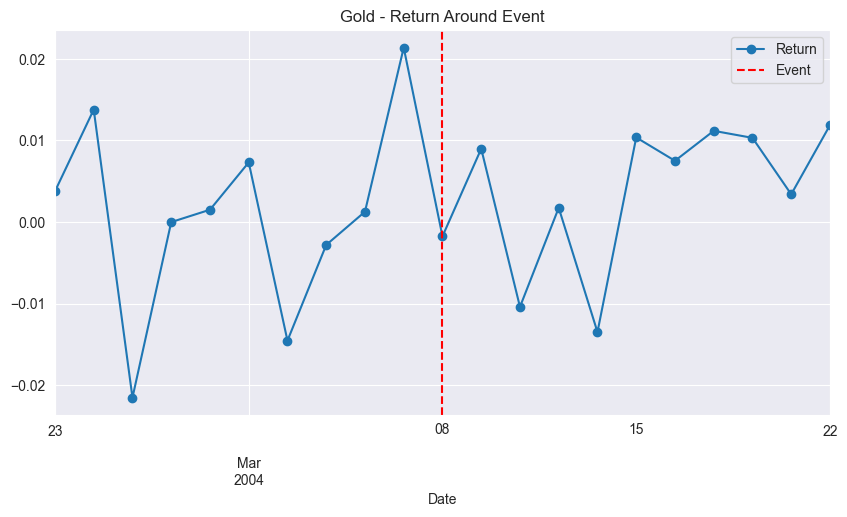


--- Event Analysis for WTI ---
Average pre-event return: 0.0036991901838200336
Average post-event return: 0.002030173584862671


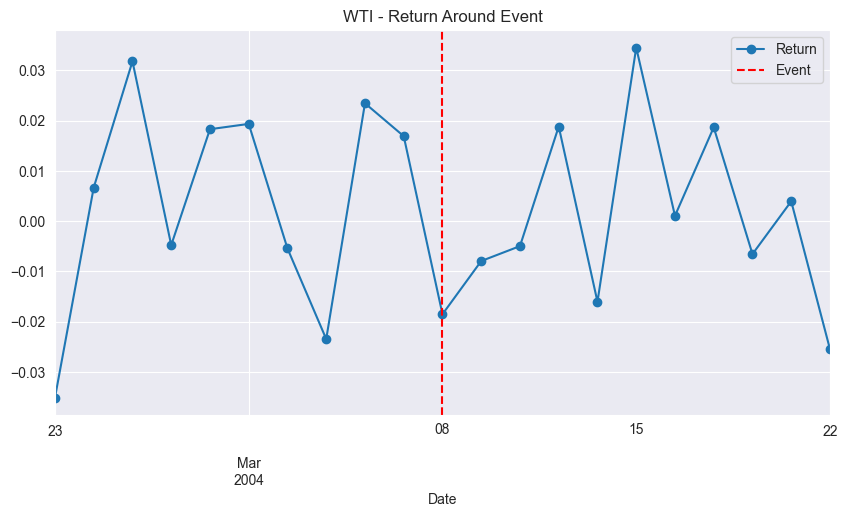


--- Event Analysis for Wheat ---
Average pre-event return: -0.0011435570424257802
Average post-event return: 0.011981996826898956


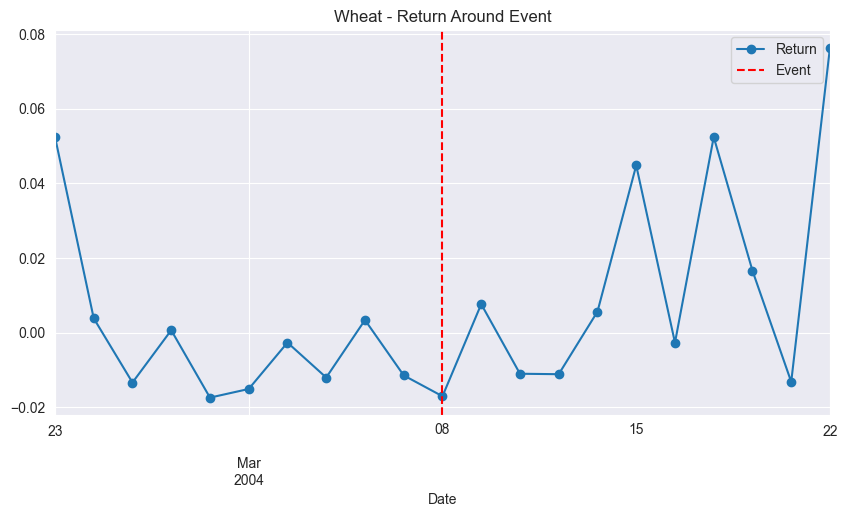


--- Event Analysis for NaturalGas ---
Average pre-event return: 0.0034358904109997534
Average post-event return: 0.002609273533438172


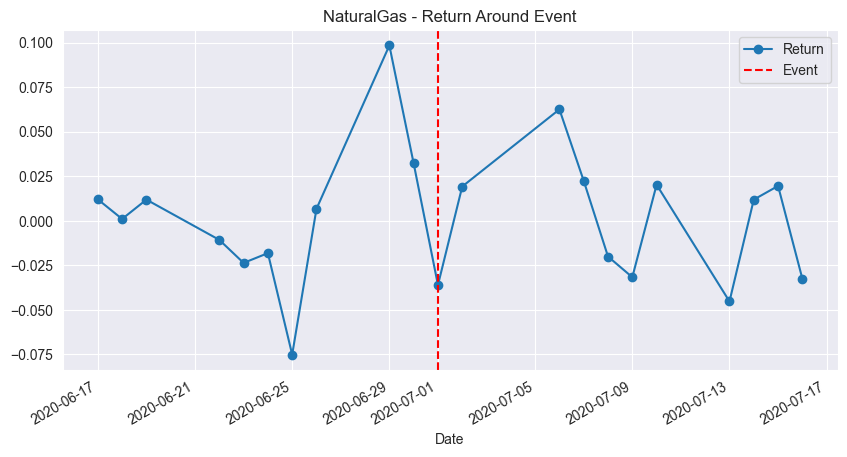


--- Event Analysis for Copper ---
Average pre-event return: 0.004114478515804893
Average post-event return: 0.005537248556321128


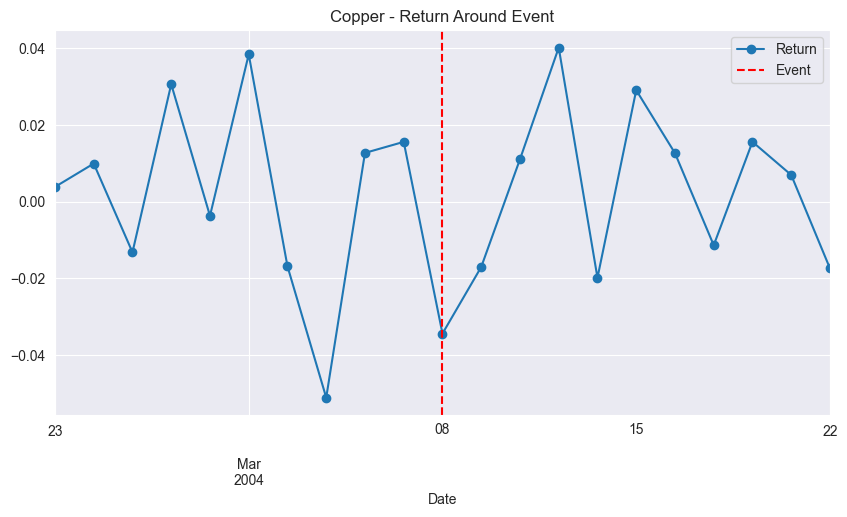


--- Event Analysis for Lithium ---
Average pre-event return: 0.0026350794166829505
Average post-event return: 0.011485955235998425


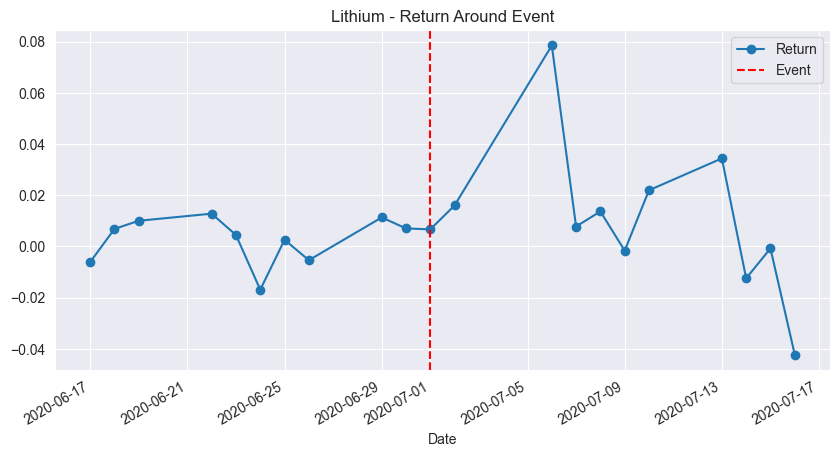

In [29]:
import matplotlib.pyplot as plt

event_window = 10  # Days before and after event

for name, df in merged_data.items():
    print(f"\n--- Event Analysis for {name} ---")
    if 'event_dummy' in df.columns and df['event_dummy'].sum() > 0:
        event_indices = df.index[df['event_dummy']==1].tolist()
        pre_event_returns, post_event_returns = [], []
        for idx in event_indices:
            if idx>event_window and idx<len(df)-event_window:
                pre_event_returns.append(df.loc[idx-event_window:idx-1, 'Return'].mean())
                post_event_returns.append(df.loc[idx+1:idx+event_window, 'Return'].mean())

        print("Average pre-event return:", np.mean(pre_event_returns))
        print("Average post-event return:", np.mean(post_event_returns))

        # Plot for one example event window (the first event)
        if event_indices:
            idx = event_indices[0]
            fig, ax = plt.subplots(figsize=(10,5))
            window_df = df.loc[idx-event_window:idx+event_window]
            window_df = window_df.set_index('Date')
            window_df['Return'].plot(ax=ax, marker='o')
            ax.axvline(df.loc[idx, 'Date'], color='red', linestyle='--', label='Event')
            plt.title(f"{name} - Return Around Event")
            plt.legend()
            plt.show()
    else:
        print("No event dummies found in data, skipping event analysis.")



--- Event Analysis and Visualization for Gold ---


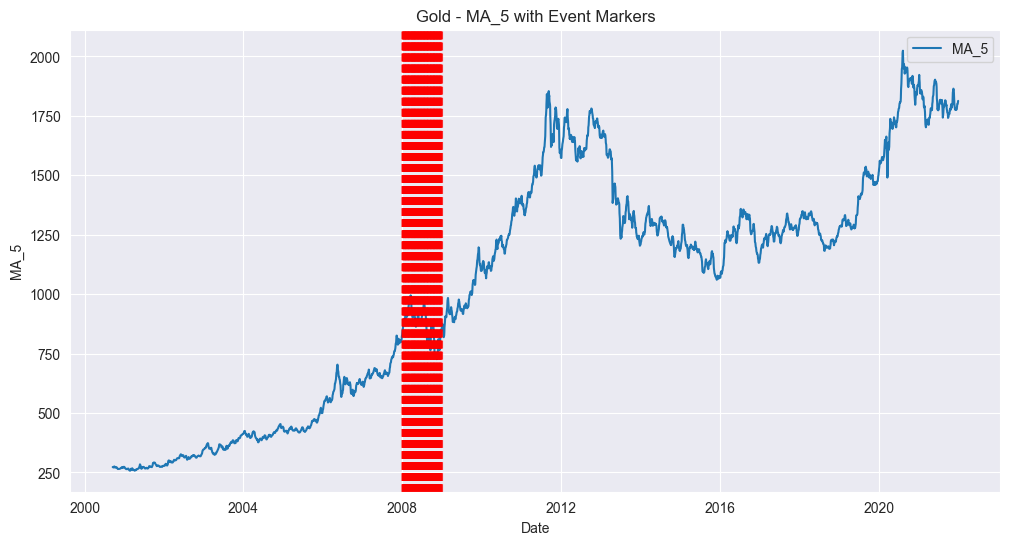

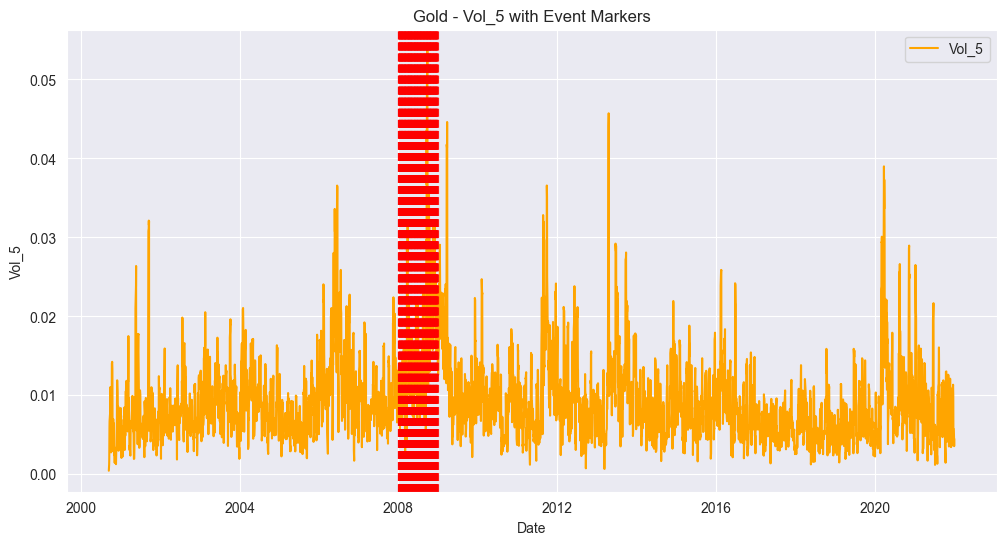

Mean volatility pre-event Vol_5:  0.0087
Mean volatility post-event Vol_5: 0.0113

--- Event Analysis and Visualization for WTI ---


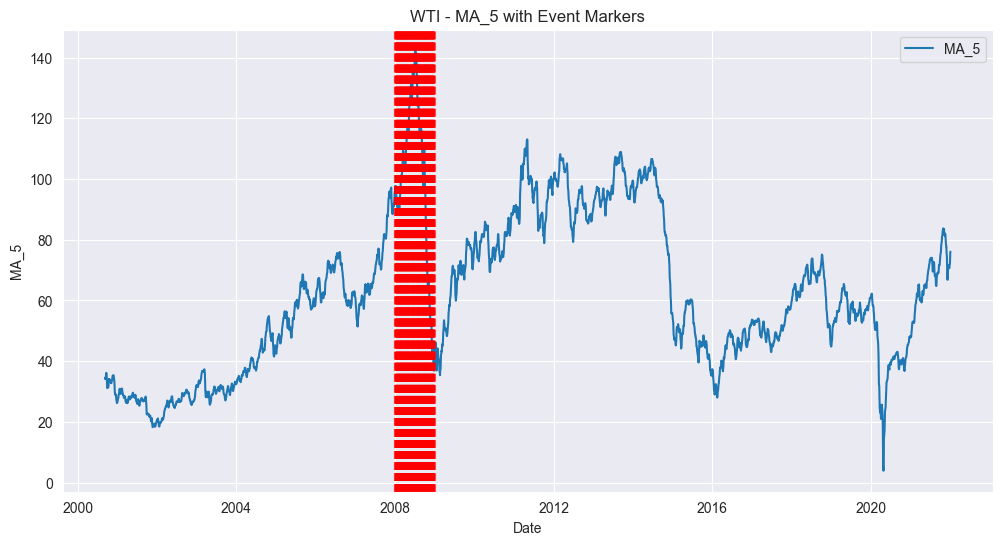

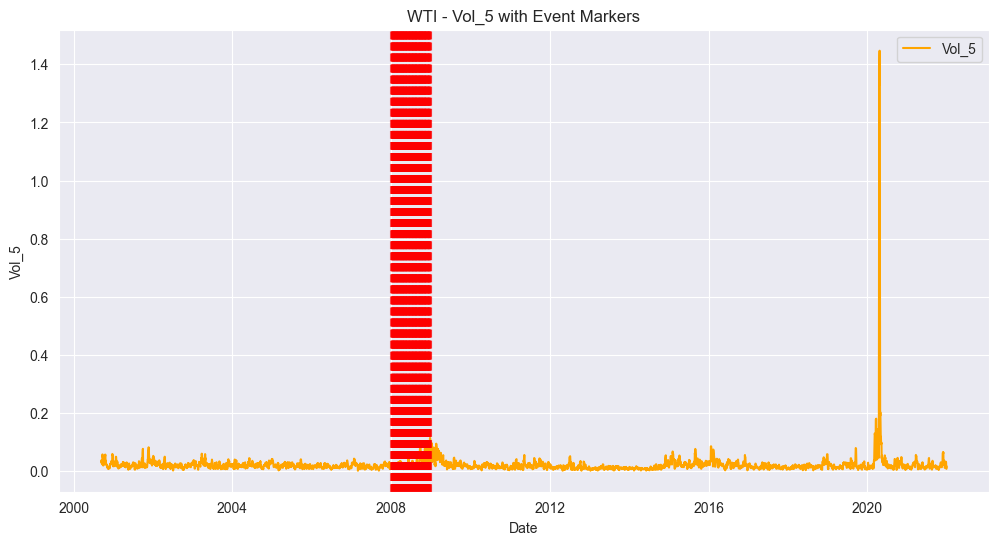

Mean volatility pre-event Vol_5:  0.0142
Mean volatility post-event Vol_5: 0.0183

--- Event Analysis and Visualization for Wheat ---


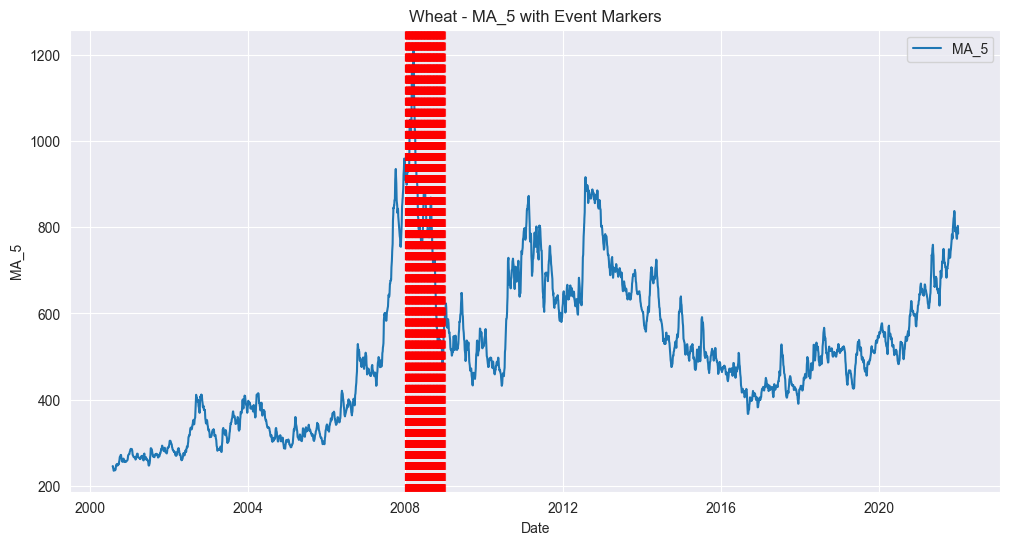

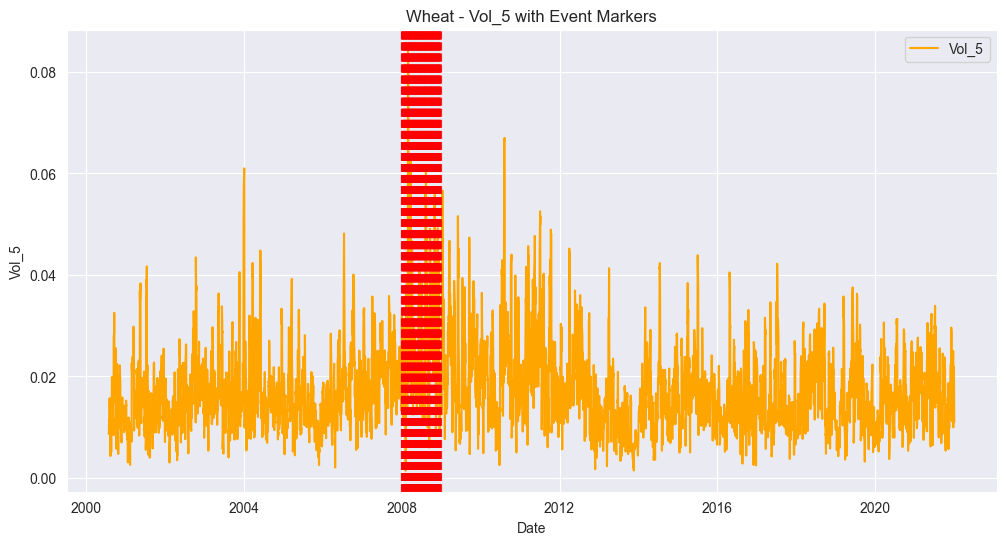

Mean volatility pre-event Vol_5:  0.0190
Mean volatility post-event Vol_5: 0.0235

--- Event Analysis and Visualization for NaturalGas ---


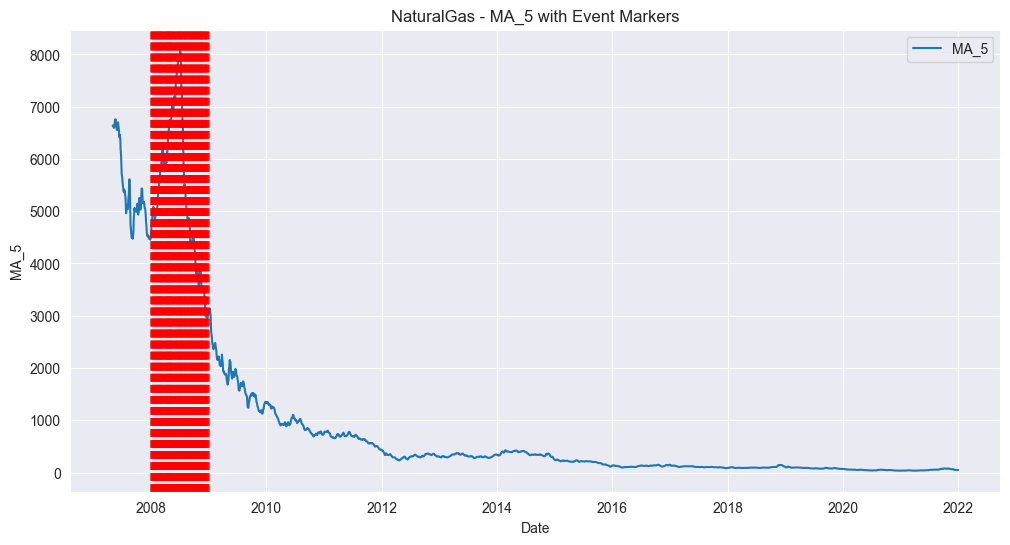

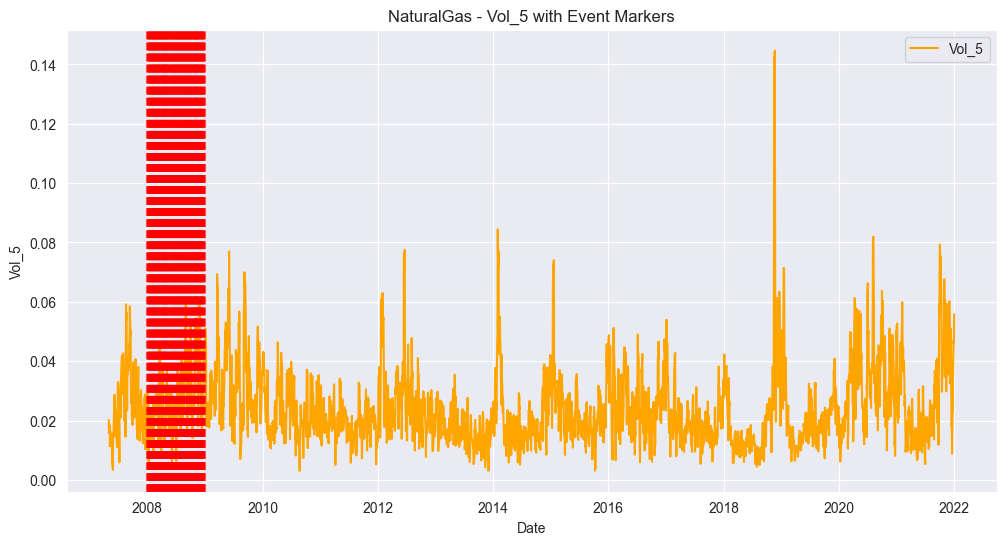

Mean volatility pre-event Vol_5:  0.0170
Mean volatility post-event Vol_5: 0.0215

--- Event Analysis and Visualization for Copper ---


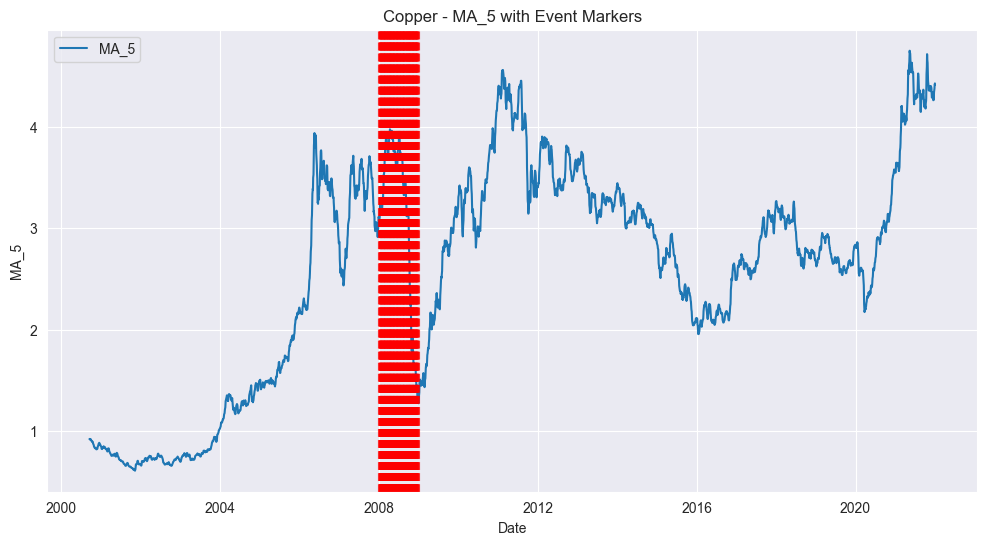

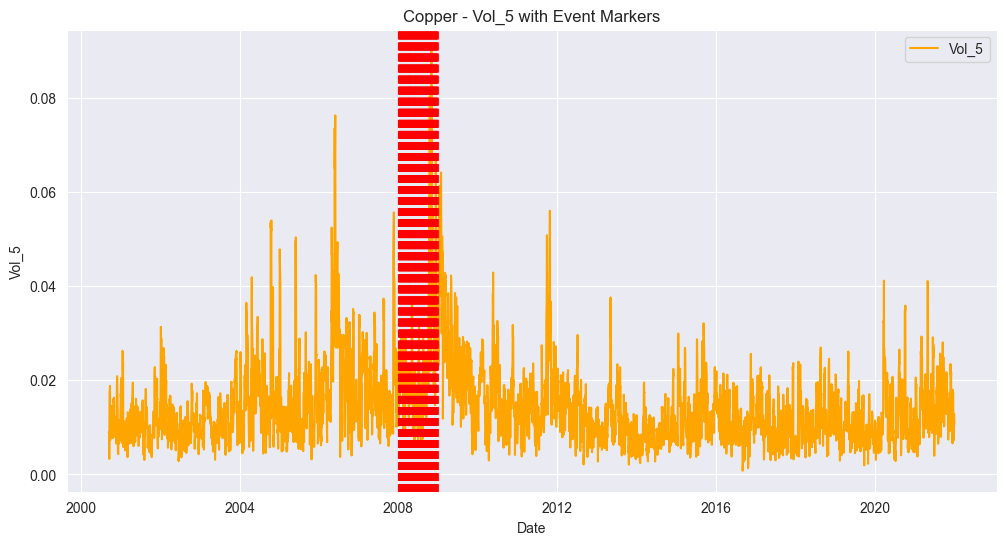

Mean volatility pre-event Vol_5:  0.0185
Mean volatility post-event Vol_5: 0.0219

--- Event Analysis and Visualization for Lithium ---


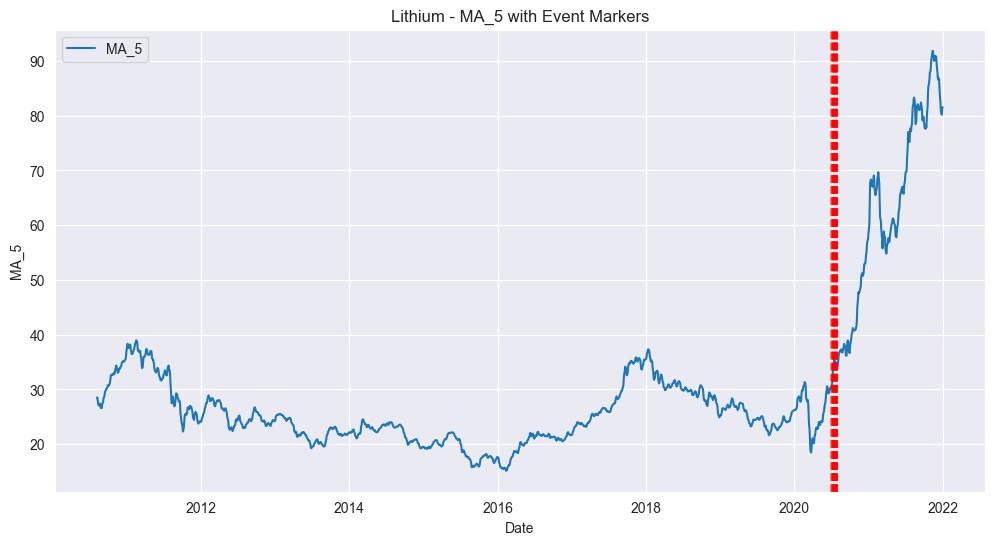

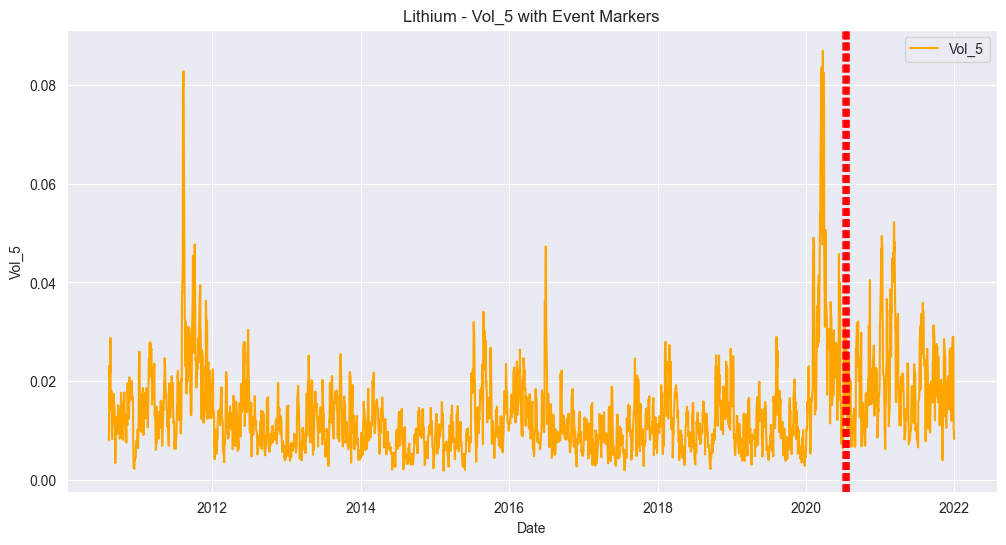

Mean volatility pre-event Vol_5:  0.0151
Mean volatility post-event Vol_5: 0.0245


In [30]:
import matplotlib.pyplot as plt

for name, df in merged_data.items():
    print(f"\n--- Event Analysis and Visualization for {name} ---")
    # Determine event dates: 2008 for most, July 2020 for lithium
    if name.lower() == 'lithium':
        event_dates = df[(df['Date'] >= '2020-07-01') & (df['Date'] < '2020-08-01')]['Date']
    else:
        event_dates = df[df['Date'].dt.year == 2008]['Date']

    # Plot MA_5 with all events marked
    if 'MA_5' in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['MA_5'], label='MA_5')
        for ed in event_dates:
            plt.axvline(ed, color='red', linestyle='--', alpha=0.4)
        plt.title(f"{name} - MA_5 with Event Markers")
        plt.xlabel("Date")
        plt.ylabel("MA_5")
        plt.legend()
        plt.show()

    # Plot Vol_5 with all events marked
    if 'Vol_5' in df.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['Vol_5'], color='orange', label='Vol_5')
        for ed in event_dates:
            plt.axvline(ed, color='red', linestyle='--', alpha=0.4)
        plt.title(f"{name} - Vol_5 with Event Markers")
        plt.xlabel("Date")
        plt.ylabel("Vol_5")
        plt.legend()
        plt.show()

    # Optional: Print mean volatility pre/post-event for quick check
    if len(event_dates) > 0 and 'Vol_5' in df.columns:
        # Use first event only for simple analysis
        idx = df.index[df['Date']==event_dates.iloc[0]][0]
        window = 10
        if idx > window and idx < len(df)-window:
            pre = df.loc[idx-window:idx-1, 'Vol_5'].mean()
            post = df.loc[idx+1:idx+window, 'Vol_5'].mean()
            print(f"Mean volatility pre-event Vol_5:  {pre:.4f}")
            print(f"Mean volatility post-event Vol_5: {post:.4f}")
